# USER MANUAL: How to use the simulator 

There are several major changes and mathematical fixes in this version

1. Encoding amino acid sequences in a naive one-hot encoding leads to a rather large null space, making the *in silico* model ill-defined, meaning, the independent and epistatic (pairwise) interactions are ambiguous, and many choices lead to the same response. This also means that the learning problem of this *in silico* weights is *ill-posed*---in the formal definition of *ill-posed porblems*
2. The encoding can be fixed to eliminate the null space. See notes. The main insight is to encode only the mutations from the parents in variable length minimal encoding with all weights interpretted as relative to parent sequence, and carefully constrain the epistatic interactions such that they cannot be explained away by independent interactions.
3. Having fixed this encoding and null space problem, one can actually learn the *in silico* model exactly, and therefore, the learning algorithm now has mathematical gurantees to learn real-life indepdent and episatatic interactions. This ends up creating a fitting / ML model that's novel---the protein or the nucleic acid litearature hasn't reported such a algorithm to learn indpendent and epistatic interactions under limited mutagenesis exactly

I expect this learning algorithm to do well for active learning policies, Designof Experiments and even fitting. The reponse here is assumed to be linear, but one can empirtically transfrom a complex response function to make it quasi-linear and additive effects of independent and pairwise interactions. 



In [57]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from Bio.Data import IUPACData
from collections import defaultdict
from itertools import product, combinations
from scipy.spatial.distance import hamming
import scipy.stats as ss
import cvxpy as cp
import sys
from scipy.linalg import null_space

sys.path.append("../") 
import doe_utils

# TEST MAKE AMINO ACID WORLD SMALL 

AMINO_ACIDS = doe_utils.AMINO_ACIDS

# For simulation, create a random parent amino acid sequence to create SOLD libraries from

This is an example of a fully *in silico* SOLD to test and understand the simulator. The functions in the simulator are written such that we can develop models from a given SOLD matrix.
Deep mutational scan at multiple locaitons also conform to the same SOLD matrix abstraction 

## Pretend that a set of positions in the protein is mutated: create a sythesis SOLD matrix

In [6]:
length_of_protein = 100 # total length of the protein
num_mutated = 6 # number of positions mutations 

# mut probs are childen mutation probs, randomly assigned to a amino acid 
# parent prob are the probabilities of the parent amino acid 
sold_mat_df, parent, mut_dict = doe_utils.create_synthetic_SOLD_matrix(num_mutated, length_of_protein,             
                                mut_probs = [[0.45, 0.45], [0.45, 0.45], [0.25, 0.3, 0.35], [0.25, 0.25, 0.4], [0.45, 0.45], [0.25, 0.25, 0.25, 0.20]], parent_prob=[0.10, 0.10, 0.10, 0.10, 0.10, 0.05]) 
sold_mat_df.head() 
    

Parent protein: GERNAMNSSWMGKHPRQQADMKDTKSDPRRYNVGEGGNTAVPQQFHTFRKTLWIMGDKALQDCMTCFVYDMIMAWFIPHAWGYWWRRMGGRMEGEQALLA
Random mutaed positions [ 1 15 27 38 50 85]


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
F,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Plot the SOLD matrix 

In real life you could simply load the sold matrix or .. see below...

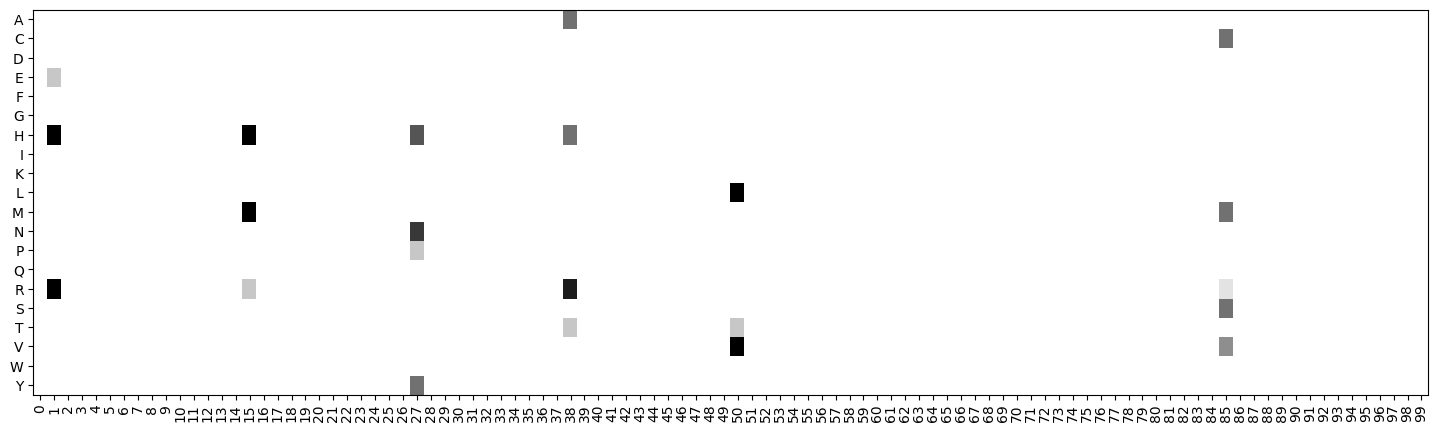

In [7]:
plt.figure(figsize = (18,5))
plt.imshow(sold_mat_df, aspect = 'auto', cmap = 'grey_r') 
_  = plt.xticks(range(length_of_protein), rotation = 90)
_  = plt.yticks(range(len(AMINO_ACIDS)), AMINO_ACIDS)


# Now let's  draw mutated sequences from this matrix 

All the tools below will work with any experimentalist provided SOLD mat or a dict, see below 

In [9]:
S = doe_utils.SOLD(sold_mat_df)
seqs, mutations = S.generate_sequences(10000)
seqs = np.unique(seqs) 
print('Num seqs ', len(seqs)) 

Num seqs  1539


# Exactly compute the probability of mutations 

In [11]:
probs = S.compute_prob_n_mutations(num_mutated+1)

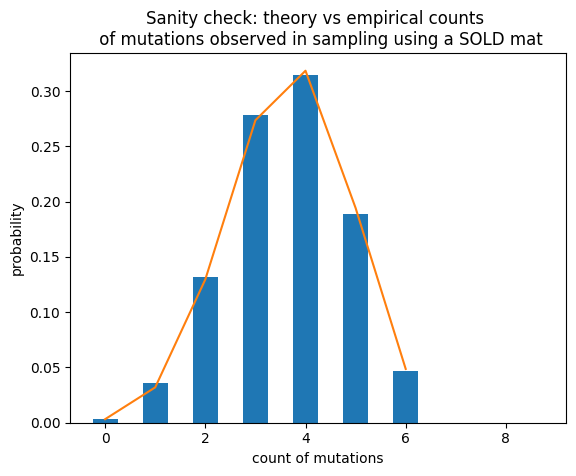

In [13]:
plt.hist(mutations, bins= np.array(range(10)) - 0.25, density = True, align = "mid", width = 0.5) 
plt.ylabel('probability')
plt.xlabel('count of mutations') 
plt.plot(probs)
_ = plt.title("Sanity check: theory vs empirical counts \n of mutations observed in sampling using a SOLD mat")

# Note: you can also use a dict as a schema for the SOLD matrix-- the key dict is of the form...

position as keys, amino acids and probs dict as values 

In [14]:
S.mutation_probs_variable_region_indexed

defaultdict(None,
            {0: {'E': 0.1, 'H': 0.45, 'R': 0.45},
             1: {'H': 0.45, 'M': 0.45, 'R': 0.1},
             2: {'H': 0.3, 'N': 0.35, 'P': 0.1, 'Y': 0.25},
             3: {'A': 0.25, 'H': 0.25, 'R': 0.4, 'T': 0.1},
             4: {'L': 0.45, 'T': 0.1, 'V': 0.45},
             5: {'C': 0.25, 'M': 0.25, 'R': 0.05, 'S': 0.25, 'V': 0.2}})

# Let's try to understand the enocder 

I have a base class for Encoder that does all the heavy lifting for how to encode. 

In [24]:
Enc_basic = doe_utils.Encoding_basics(S.mutation_probs_variable_region_indexed)


## Independent codes are ... note the varible lengths and the parent value is mapeed to zero vector

In [25]:
Enc_basic.independent_code_mapper

{0: {'E': array([1., 0.]), 'R': array([0., 1.]), 'H': array([0., 0.])},
 1: {'M': array([1., 0.]), 'R': array([0., 1.]), 'H': array([0., 0.])},
 2: {'H': array([1., 0., 0.]),
  'P': array([0., 1., 0.]),
  'Y': array([0., 0., 1.]),
  'N': array([0., 0., 0.])},
 3: {'A': array([1., 0., 0.]),
  'H': array([0., 1., 0.]),
  'T': array([0., 0., 1.]),
  'R': array([0., 0., 0.])},
 4: {'T': array([1., 0.]), 'V': array([0., 1.]), 'L': array([0., 0.])},
 5: {'M': array([1., 0., 0., 0.]),
  'R': array([0., 1., 0., 0.]),
  'S': array([0., 0., 1., 0.]),
  'V': array([0., 0., 0., 1.]),
  'C': array([0., 0., 0., 0.])}}

## The pairwise mapper is complicated, but note that all single mutations compared to parent (meaning, dimers with one position being parent amino) are excluded, because they can be explained away by independent weights 

In [26]:
Enc_basic.pairwise_code_mapper

{'0:1': {'EM': array([1., 0., 0., 0.]),
  'ER': array([0., 1., 0., 0.]),
  'RM': array([0., 0., 1., 0.]),
  'RR': array([0., 0., 0., 1.]),
  'HH': array([0., 0., 0., 0.]),
  'EH': array([0., 0., 0., 0.]),
  'HM': array([0., 0., 0., 0.]),
  'HR': array([0., 0., 0., 0.]),
  'RH': array([0., 0., 0., 0.])},
 '0:2': {'EH': array([1., 0., 0., 0., 0., 0.]),
  'EP': array([0., 1., 0., 0., 0., 0.]),
  'EY': array([0., 0., 1., 0., 0., 0.]),
  'RH': array([0., 0., 0., 1., 0., 0.]),
  'RP': array([0., 0., 0., 0., 1., 0.]),
  'RY': array([0., 0., 0., 0., 0., 1.]),
  'HN': array([0., 0., 0., 0., 0., 0.]),
  'EN': array([0., 0., 0., 0., 0., 0.]),
  'HH': array([0., 0., 0., 0., 0., 0.]),
  'HP': array([0., 0., 0., 0., 0., 0.]),
  'HY': array([0., 0., 0., 0., 0., 0.]),
  'RN': array([0., 0., 0., 0., 0., 0.])},
 '0:3': {'EA': array([1., 0., 0., 0., 0., 0.]),
  'EH': array([0., 1., 0., 0., 0., 0.]),
  'ET': array([0., 0., 1., 0., 0., 0.]),
  'RA': array([0., 0., 0., 1., 0., 0.]),
  'RH': array([0., 0., 0

# Create a proper encoder... Encoder basics is a base class ... and shown above just to expose it

Encoder encodes both inpdendent and pairwise, and returns them seperately... you can create different in silico models, with only inpdendent, or both 

In [27]:
Encoder = doe_utils.Sequence_encoder_simplex(S.mutation_probs_variable_region_indexed)
independent_codes, pairwise_codes, flatten_independent, flatter_pairwise = Encoder.encode_seqs(seqs)

# Create in silico model data generator

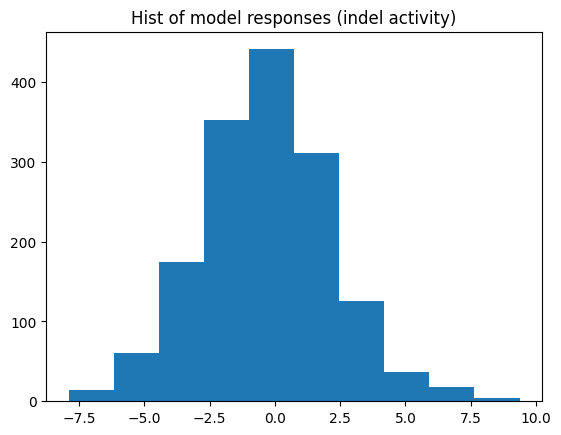

In [44]:
# you can choose the sparse mixture model for independent and pairwise params 
I_defaults = {'rho':[0.25, 0.25], 'sparse_pdf_names': ['norm', 'norm'], 'noise_sigma' : 0.1, 'sparse_params': [{'loc': 1, 'scale': 0.1}, {'loc': -1, 'scale': 0.1}]} 
P_defaults = {'rho':[0.35, 0.35], 'sparse_pdf_names': ['norm', 'norm'], 'noise_sigma' : 0.1, 'sparse_params': [{'loc': 0.75, 'scale': 0.1}, {'loc': -0.75, 'scale': 0.1}]} 

Insilico_model = doe_utils.Create_in_silico_model(S.mutation_probs_variable_region_indexed, independent_params= I_params, pairwise_params= P_params)
# get respomses, here I am using both independent and pairwise
responses = Insilico_model.model(flatten_independent, flatter_pairwise)
_ = plt.hist(responses)
_ = plt.title('Hist of model responses (indel activity)') 

# Visualize the distribution of weights assigned 

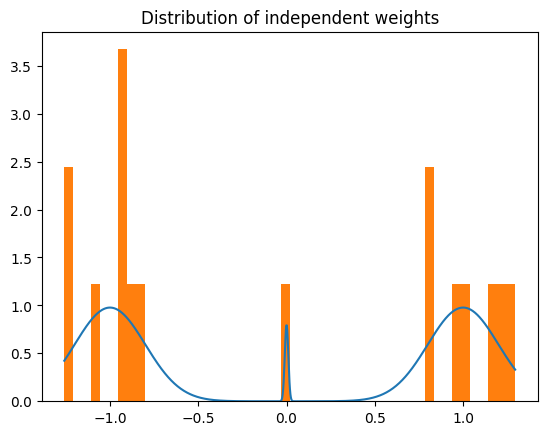

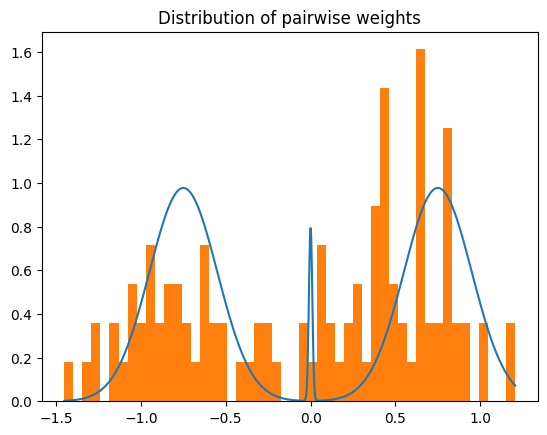

In [45]:
Insilico_model.plot_weights()

## Note pairwise weights had to be normalized to make sure it doesn't have independent weight components, so the distribution you chose from will not agree witht the actual weights 

# Create fitting model 

In [47]:
fit_model = doe_utils.Fitting_model(S.mutation_probs_variable_region_indexed)
# Note, I am using both ... independent and pairiwise fitting... see options in function
weights, fit_responses = fit_model.fit(seqs, responses, fit = 'both')

# Plot learned vs ground truth responses 

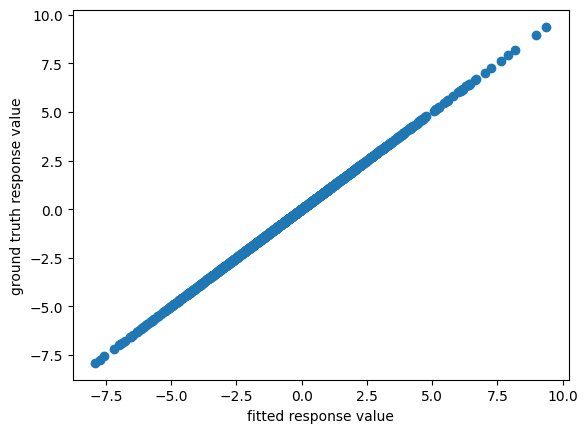

In [49]:
plt.scatter(fit_responses, responses)
_ = plt.xlabel('fitted response value') 
_ = plt.ylabel('ground truth response value') 

# Do we fit independent weights well and unambiguously? No null space

Text(0, 0.5, 'fitted independent weights')

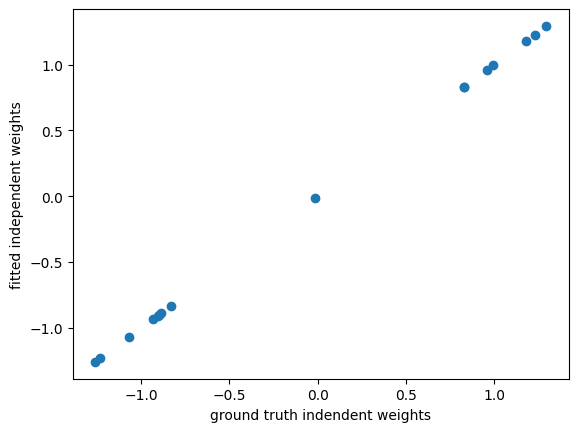

In [51]:
# note the fit model returns all weights as vector ... the indices of independent weights are gotten as such..
plt.scatter(Insilico_model.independent_weights, weights[fit_model.independent_indices])   
plt.xlabel("ground truth indendent weights") 
plt.ylabel('fitted independent weights') 

# Do we fit pairiwise weights well and unambiguously? No null space

Text(0, 0.5, 'fitted pairwise weights')

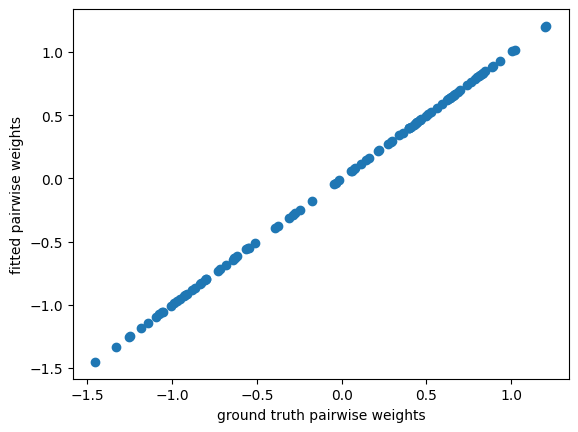

In [54]:
plt.scatter(Insilico_model.pairwise_weights, weights[fit_model.pairwise_indices])
plt.xlabel("ground truth pairwise weights") 
plt.ylabel('fitted pairwise weights') 

# Check for design matrix null space 

Null space basis vectors:
[]


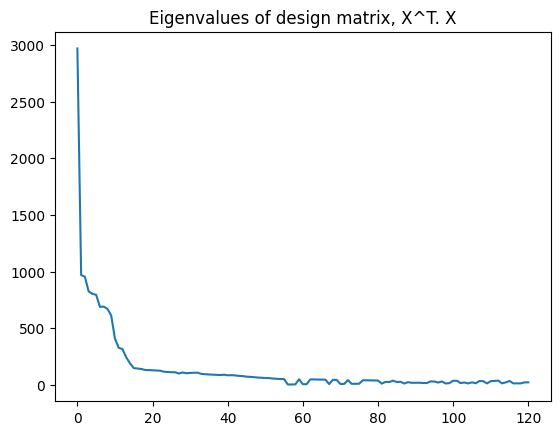

In [60]:
eigs, _ = np.linalg.eig(fit_model.features.T.dot(fit_model.features))
plt.plot(eigs)
_ = plt.title("Eigenvalues of design matrix, X^T. X")

ns = null_space(fit_model.features.T.dot(fit_model.features))
print("Null space basis vectors:")
print(ns.T)

Text(0.5, 0, 'Feature names')

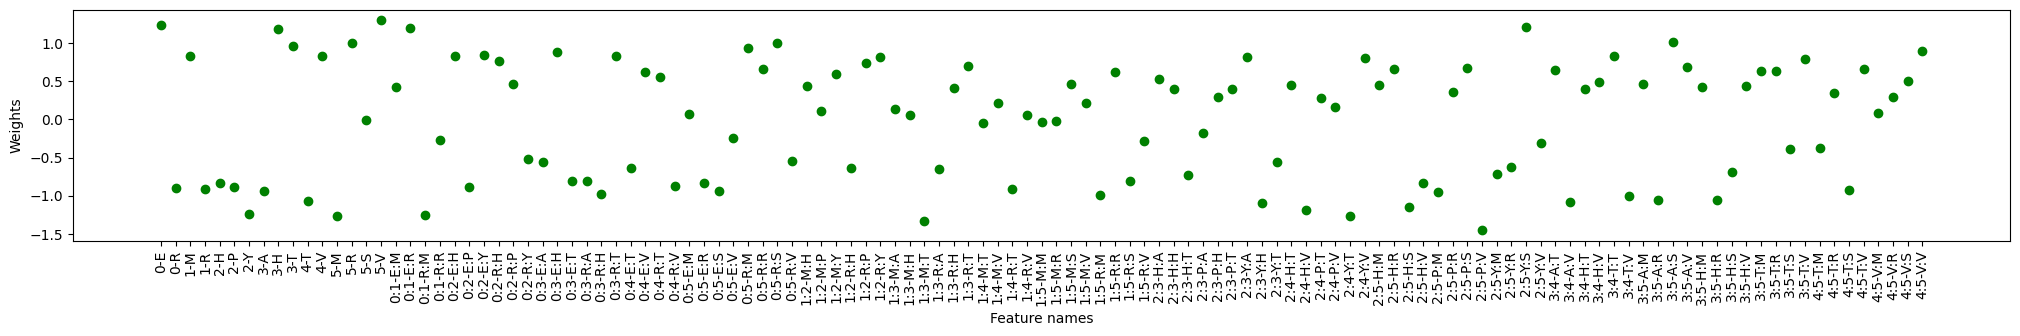

In [70]:
plt.figure(figsize = (25,3))
plt.plot(weights, linestyle = 'None', marker = 'o', color = 'green') 
_ = plt.xticks(range(Encoder.number_of_features), np.concatenate([Encoder.flattened_independent_position_weights_name, Encoder.flattened_pair_position_weights_name]), rotation = 90)
plt.ylabel('Weights')
plt.xlabel('Feature names') 

# You can now use this fitting model to fit real life data